In [114]:
import numpy as numpy
import pandas as pd 


In [115]:
import os
os.path.abspath(os.getcwd())

'e:\\Alireza\\Uppsala\\Classes\\Data_Mining\\Project'

In [116]:
df = pd.read_csv("European_citiznes_rsvp.csv")
df.head()

,COUNTRY,SEX,YEAR,life_expectancy,average_number_of_calories_available_per_person_per_day,unemployment_rate,regular_daily_smokers,adult_overweight,alcahol_consumption_liter_per_capita,fat_available_ppd,protein_ppd,average_fruit_vegtable_ppd
0,Austria,ALL,2000.0,78.47,2223.0,5.6,29.5,33.3,1.17,44.85,66.11,128.80
1,Austria,ALL,2001.0,78.95,2242.0,5.1,40.1,33.8,0.91,46.06,66.12,121.44
2,Austria,ALL,2002.0,79.01,2156.0,3.6,24.7,34.2,1.04,43.14,64.58,115.27
3,Austria,ALL,2003.0,78.89,2270.0,4.4,34.9,34.7,1.04,48.29,65.59,127.38
4,Austria,ALL,2004.0,79.43,2254.0,5.7,39.0,35.1,1.03,44.41,66.63,120.52


In [117]:
import pandas as pd
import numpy as np

# --- 0) Assume df already loaded with your columns ---
# df.columns == ['COUNTRY','SEX','YEAR','life_expectancy',
# 'average_number_of_calories_available_per_person_per_day','unemployment_rate',
# 'regular_daily_smokers','adult_overweight','alcahol_consumption_liter_per_capita',
# 'fat_available_ppd','protein_ppd','average_fruit_vegtable_ppd']

# 1) Sanity & coverage
summary = {
    "n_rows": len(df),
    "n_countries": df["COUNTRY"].nunique(),
    "years_min": df["YEAR"].min(),
    "years_max": df["YEAR"].max(),
    "sex_levels": df["SEX"].unique().tolist(),
}
missing = df.isna().mean().sort_values(ascending=False)  # share missing per column

# 2) Per-country trend features (slopes and percent change)
def slope(y, x):
    if len(y.dropna()) < 3: return np.nan
    x = x.astype(float)
    y = y.astype(float)
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return m

trend_cols = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
    "unemployment_rate",
]

# Work on total (collapse SEX if you have both M/F): take average across SEX within country-year
df_tot = (df.groupby(["COUNTRY","YEAR"], as_index=False)
            [trend_cols].mean())

# Slopes per country
slopes = (df_tot
          .groupby("COUNTRY")
          .apply(lambda g: pd.Series({f"{c}_slope": slope(g[c], g["YEAR"]) for c in trend_cols}))
          .reset_index())

# Percent change 2002 -> 2022
def pct_change_2002_2022(g, col):
    g = g.sort_values("YEAR")
    first = g.loc[g["YEAR"].idxmin(), col] if not g.empty else np.nan
    last  = g.loc[g["YEAR"].idxmax(), col] if not g.empty else np.nan
    return (last - first) / first * 100 if pd.notna(first) and first != 0 else np.nan

pctchg = (df_tot
          .groupby("COUNTRY")
          .apply(lambda g: pd.Series({f"{c}_pctchg": pct_change_2002_2022(g, c) for c in trend_cols}))
          .reset_index())

trend_table = slopes.merge(pctchg, on="COUNTRY", how="outer")

# 3) Associations with life expectancy
# 3a) Overall Pearson correlations (latest year only, e.g., 2022)
latest_year = df_tot["YEAR"].max()
snap = df_tot[df_tot["YEAR"] == latest_year].copy()
corr_cols = ["life_expectancy","average_number_of_calories_available_per_person_per_day",
             "regular_daily_smokers","adult_overweight","alcahol_consumption_liter_per_capita",
             "fat_available_ppd","protein_ppd","average_fruit_vegtable_ppd","unemployment_rate"]
corr_latest = snap[corr_cols].corr().loc["life_expectancy"].sort_values(ascending=False)

# 3b) Within-country correlations (demeaned by country)
def demean_by_country(d, cols):
    return d.assign(**{c: d[c] - d.groupby("COUNTRY")[c].transform("mean") for c in cols})
dm = demean_by_country(df_tot, corr_cols)
corr_within = dm[corr_cols].corr().loc["life_expectancy"].sort_values(ascending=False)

# 4) Quick fixed-effects style regression (no external libs)
# life_expectancy ~ calories + smokers + alcohol + unemployment + year FE
X_cols = ["average_number_of_calories_available_per_person_per_day",
          "regular_daily_smokers","alcahol_consumption_liter_per_capita",
          "unemployment_rate"]
d = df_tot.dropna(subset=["life_expectancy"] + X_cols).copy()
# Add year dummies
year_dummies = pd.get_dummies(d["YEAR"], prefix="Y", drop_first=True)
X = pd.concat([d[X_cols], year_dummies], axis=1)
X = (X - X.mean())/X.std(ddof=0)  # scale for comparability
X["intercept"] = 1.0
y = d["life_expectancy"].astype(float)

# OLS via closed form
XtX = X.T @ X
Xty = X.T @ y
beta = np.linalg.pinv(XtX) @ Xty
coef = pd.Series(beta, index=X.columns).sort_values(ascending=False)

# 5) Country profiles (latest year z-scores)
Z = snap.copy()
for c in corr_cols:
    Z[c + "_z"] = (Z[c] - Z[c].mean()) / Z[c].std(ddof=0)
country_profile = Z[["COUNTRY"] + [c+"_z" for c in corr_cols]]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24424\1139811386.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({f"{c}_slope": slope(g[c], g["YEAR"]) for c in trend_cols}))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24424\1139811386.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({f"{c}_pctchg": pct_change_2002_2022(g, c) for c in trend_cols}))


In [118]:
missing

COUNTRY                                                    0.0
SEX                                                        0.0
YEAR                                                       0.0
life_expectancy                                            0.0
average_number_of_calories_available_per_person_per_day    0.0
unemployment_rate                                          0.0
regular_daily_smokers                                      0.0
adult_overweight                                           0.0
alcahol_consumption_liter_per_capita                       0.0
fat_available_ppd                                          0.0
protein_ppd                                                0.0
average_fruit_vegtable_ppd                                 0.0
dtype: float64

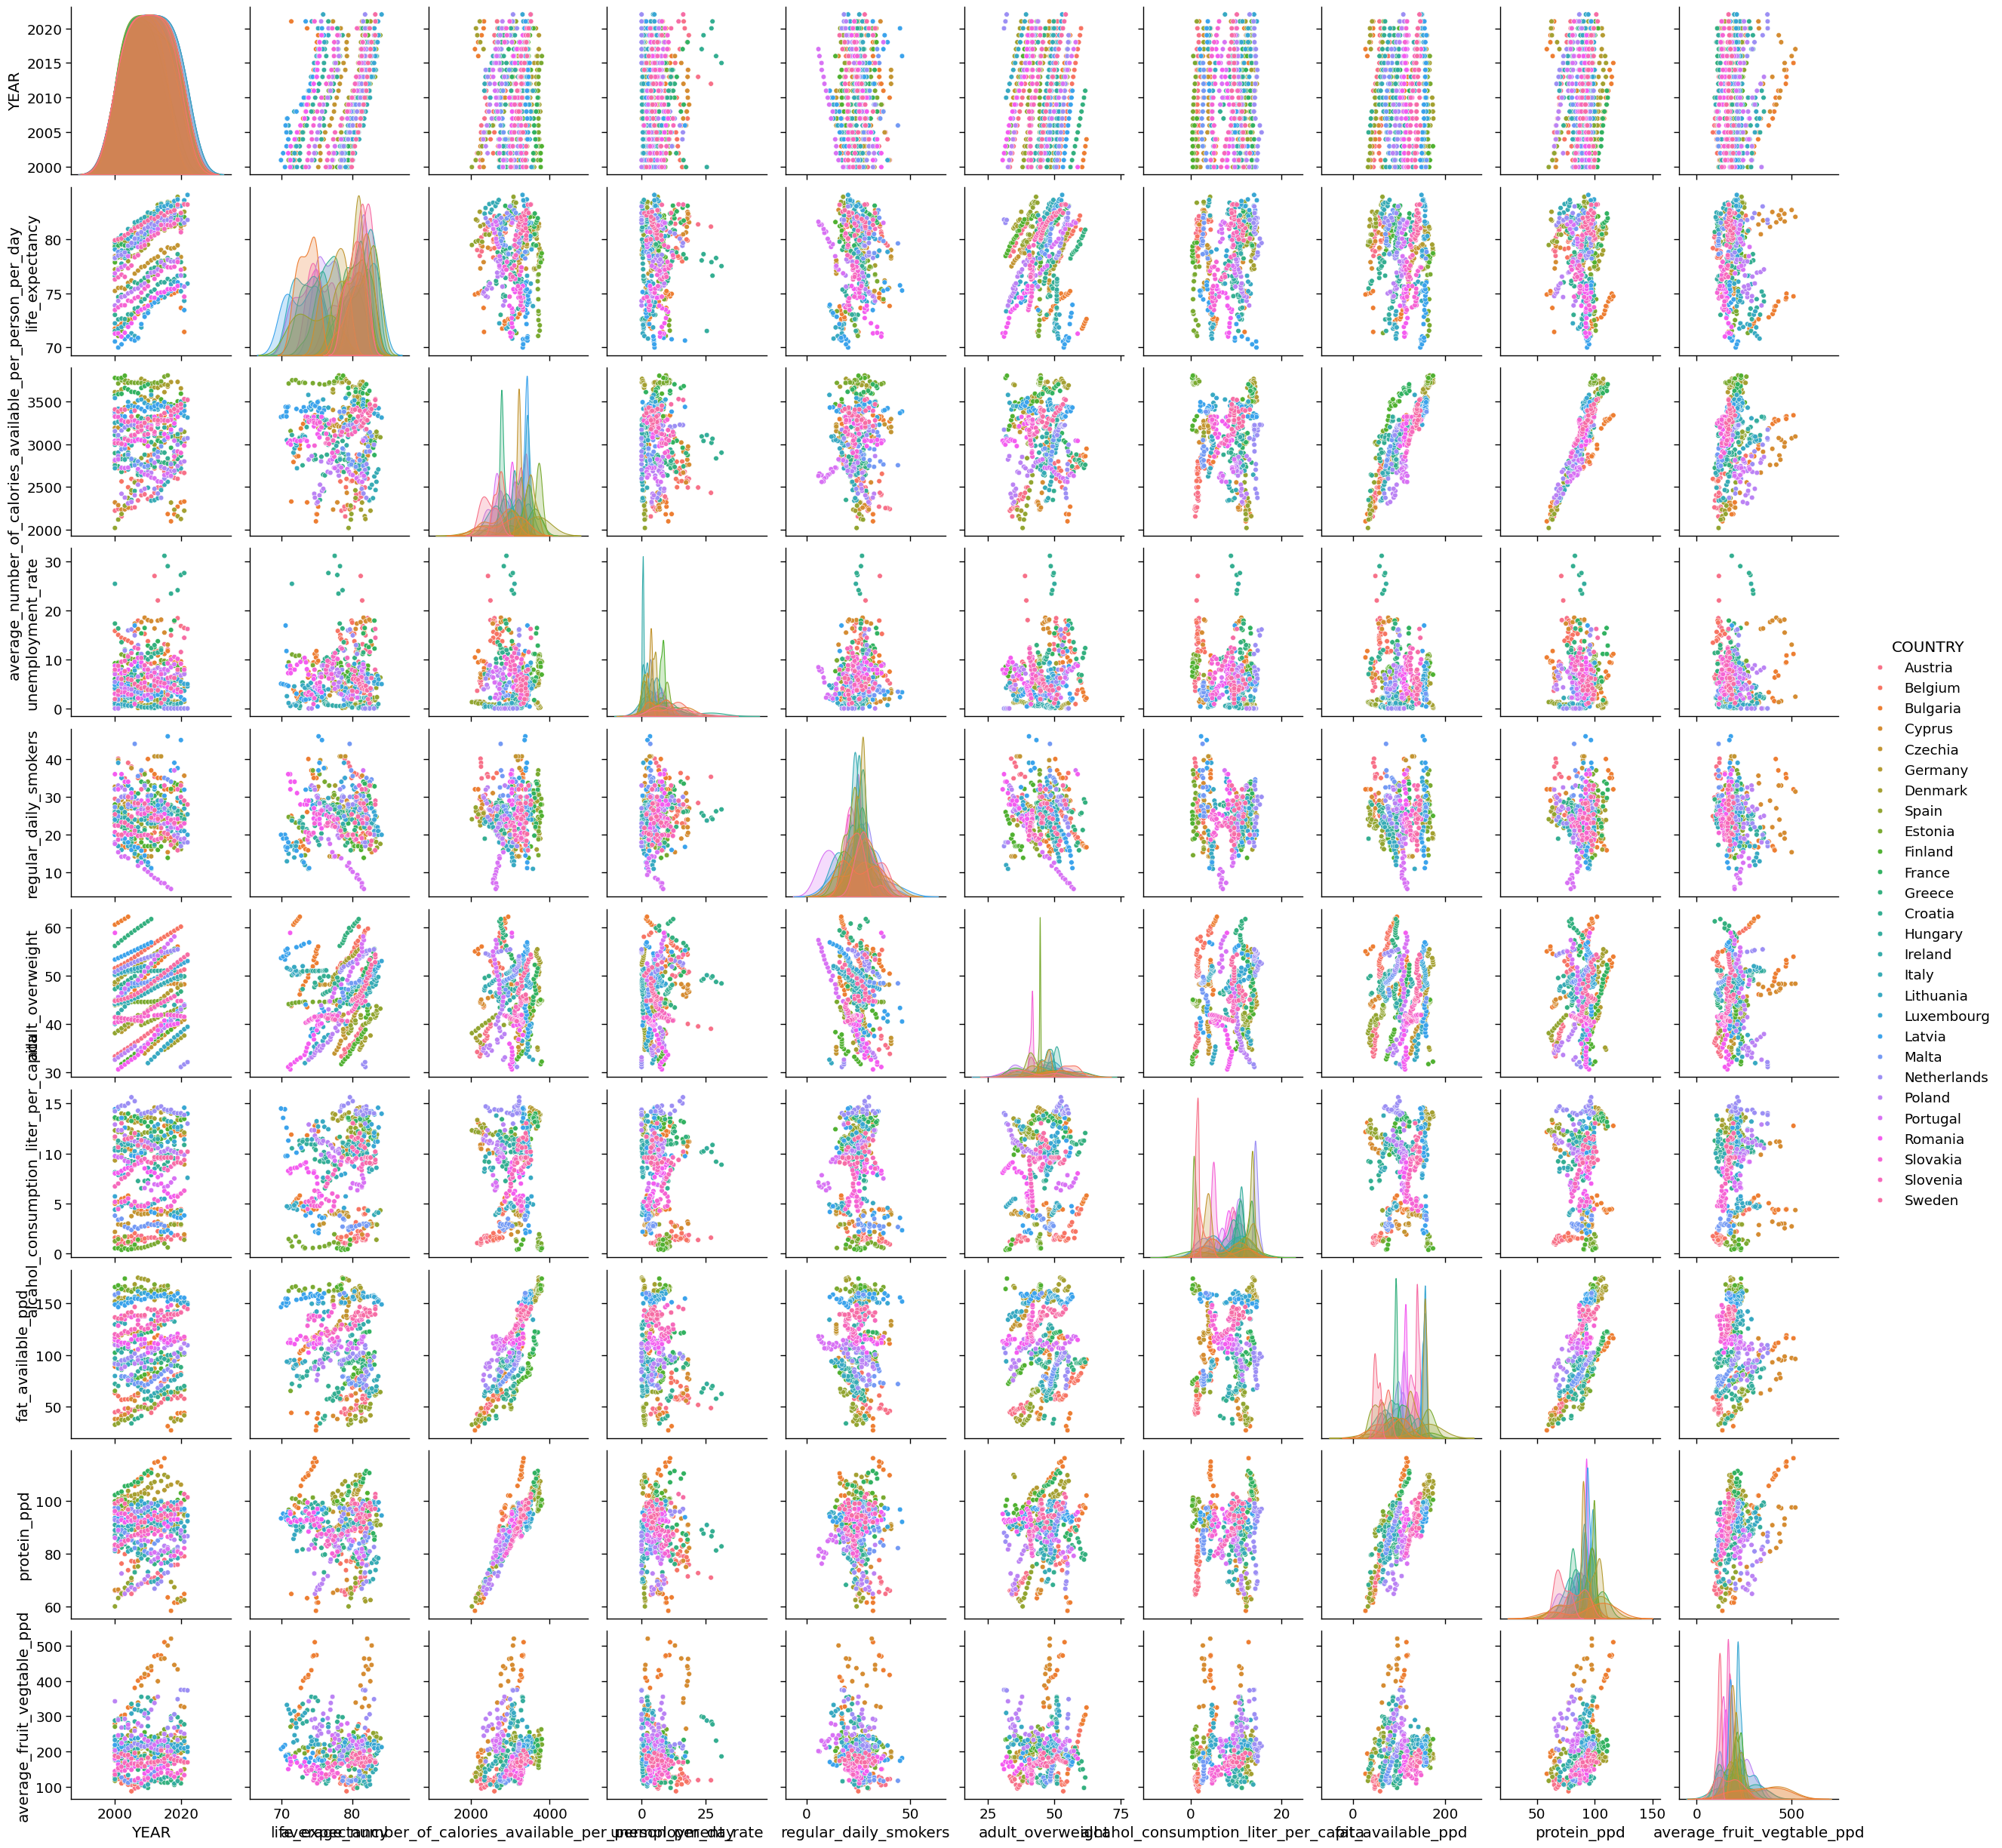

In [119]:
import seaborn as sns
sns.pairplot(df,hue="COUNTRY")

In [120]:
from scipy import stats
stats.zscore(df["life_expectancy"]).min()

np.float64(-2.5326224223821825)

In [121]:
data=df.copy()
data.COUNTRY.drop


<bound method Series.drop of 0      Austria
1      Austria
2      Austria
3      Austria
4      Austria
        ...   
553     Sweden
554     Sweden
555     Sweden
556     Sweden
557     Sweden
Name: COUNTRY, Length: 558, dtype: object>

In [122]:
data . drop ([ 'COUNTRY'] , axis =1 , inplace = True )


In [123]:
import pandas as pd
import numpy as np


def tertile_labels(s):
   
    return pd.qcut(s.rank(method="first"), q=3, labels=["LOW","MID","HIGH"])

cols_to_bin = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "unemployment_rate",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
]

for c in cols_to_bin:
    df[c+"_bin"] = df.groupby("YEAR")[c].transform(tertile_labels)

# Build a string item for each binned column
rename_map = {
    "life_expectancy_bin": "LIFEEXP",
    "average_number_of_calories_available_per_person_per_day_bin": "CALORIES",
    "unemployment_rate_bin": "UNEMP",
    "regular_daily_smokers_bin": "SMOKING",
    "adult_overweight_bin": "OVERWT",
    "alcahol_consumption_liter_per_capita_bin": "ALCOHOL",
    "fat_available_ppd_bin": "FAT",
    "protein_ppd_bin": "PROTEIN",
    "average_fruit_vegtable_ppd_bin": "FRUITVEG",
}

item_cols = [c+"_bin" for c in cols_to_bin]
print(item_cols)

def row_to_items(row):
    items = []
    for c in item_cols:
        label = str(row[c])
        var = rename_map[c]
        items.append(f"{var}={label}")
    return items

# 1 transaction = one (COUNTRY, YEAR)
tx_df = (df.sort_values(["COUNTRY","YEAR"])
           .dropna(subset=item_cols)
           .drop_duplicates(subset=["COUNTRY","YEAR"]))

transactions = tx_df.apply(row_to_items, axis=1).tolist()
num_records = len(transactions)
print("Transactions:", num_records)


['life_expectancy_bin', 'average_number_of_calories_available_per_person_per_day_bin', 'unemployment_rate_bin', 'regular_daily_smokers_bin', 'adult_overweight_bin', 'alcahol_consumption_liter_per_capita_bin', 'fat_available_ppd_bin', 'protein_ppd_bin', 'average_fruit_vegtable_ppd_bin']
Transactions: 558


In [124]:
df

,COUNTRY,SEX,YEAR,life_expectancy,average_number_of_calories_available_per_person_per_day,unemployment_rate,regular_daily_smokers,adult_overweight,alcahol_consumption_liter_per_capita,fat_available_ppd,...,average_fruit_vegtable_ppd,life_expectancy_bin,average_number_of_calories_available_per_person_per_day_bin,unemployment_rate_bin,regular_daily_smokers_bin,adult_overweight_bin,alcahol_consumption_liter_per_capita_bin,fat_available_ppd_bin,protein_ppd_bin,average_fruit_vegtable_ppd_bin
0,Austria,ALL,2000.0,78.47,2223.0,5.6,29.5,33.30,1.17,44.85,...,128.80,HIGH,LOW,MID,HIGH,LOW,LOW,LOW,LOW,LOW
1,Austria,ALL,2001.0,78.95,2242.0,5.1,40.1,33.80,0.91,46.06,...,121.44,HIGH,LOW,MID,HIGH,LOW,LOW,LOW,LOW,LOW
2,Austria,ALL,2002.0,79.01,2156.0,3.6,24.7,34.20,1.04,43.14,...,115.27,HIGH,LOW,MID,MID,LOW,LOW,LOW,LOW,LOW
3,Austria,ALL,2003.0,78.89,2270.0,4.4,34.9,34.70,1.04,48.29,...,127.38,HIGH,LOW,MID,HIGH,LOW,LOW,LOW,LOW,LOW
4,Austria,ALL,2004.0,79.43,2254.0,5.7,39.0,35.10,1.03,44.41,...,120.52,HIGH,LOW,MID,HIGH,LOW,LOW,LOW,LOW,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,Sweden,ALL,2018.0,82.71,3411.0,6.2,18.4,52.23,9.00,138.58,...,175.32,HIGH,HIGH,MID,LOW,HIGH,MID,HIGH,HIGH,MID
554,Sweden,ALL,2019.0,83.22,3450.0,7.9,15.9,52.76,9.12,138.96,...,173.29,HIGH,HIGH,HIGH,LOW,HIGH,MID,HIGH,HIGH,LOW
555,Sweden,ALL,2020.0,82.46,3466.0,11.5,33.0,53.29,9.06,140.72,...,172.22,HIGH,HIGH,HIGH,HIGH,HIGH,MID,HIGH,HIGH,LOW
556,Sweden,ALL,2021.0,83.26,3527.0,14.4,29.0,53.80,9.36,146.00,...,169.74,HIGH,HIGH,HIGH,HIGH,HIGH,MID,HIGH,HIGH,LOW


In [125]:
import pyfpgrowth

# Choose minimum support as a COUNT like in your sheet:
# Example: require that an itemset appears in at least 20% of all (country,year) rows
min_support_frac = 0.20
sigma = max(1, int(np.floor(min_support_frac * num_records)))
print("Minimum support (count) =", sigma)

patterns = pyfpgrowth.find_frequent_patterns(transactions, sigma)
print("Frequent itemsets found:", len(patterns))

# Quick peek at biggest itemsets found

max_itemset_size=max(len(iset) for iset in patterns) 
print("Max frequent itemset size:", max_itemset_size)


Minimum support (count) = 111
Frequent itemsets found: 33
Max frequent itemset size: 3


In [126]:
min_conf=0.6
raw_rules=pyfpgrowth.generate_association_rules(patterns, min_conf)

In [127]:
raw_rules

{('CALORIES=MID',): (('PROTEIN=MID',), 0.6666666666666666),
 ('PROTEIN=MID',): (('CALORIES=MID',), 0.6666666666666666),
 ('CALORIES=LOW',): (('PROTEIN=LOW',), 0.8663101604278075),
 ('FAT=LOW',): (('CALORIES=LOW', 'PROTEIN=LOW'), 0.6096256684491979),
 ('CALORIES=LOW', 'FAT=LOW'): (('PROTEIN=LOW',), 0.8769230769230769),
 ('CALORIES=LOW', 'PROTEIN=LOW'): (('FAT=LOW',), 0.7037037037037037),
 ('FAT=LOW', 'PROTEIN=LOW'): (('CALORIES=LOW',), 0.926829268292683),
 ('FAT=HIGH',): (('CALORIES=HIGH',), 0.7591623036649214),
 ('CALORIES=HIGH',): (('FAT=HIGH',), 0.7591623036649214)}

In [128]:
from collections import Counter
import pandas as pd

rows = []
N = len(transactions)

for antecedent, (consequent, confidence) in raw_rules.items():
    # --- Normalize antecedent ---
    if isinstance(antecedent, (list, tuple, set, frozenset)):
        antecedent = {str(x) for x in antecedent}
    else:
        antecedent = {str(antecedent)}

    # --- Normalize consequent ---
    if isinstance(consequent, (list, tuple, set, frozenset)):
        consequent = {str(x) for x in consequent}
    else:
        consequent = {str(consequent)}

    union = antecedent | consequent

    # --- Support of union (antecedent+consequent) ---
    supp_union = sum(1 for basket in transactions if union.issubset(basket)) / N

    # --- Support of consequent ---
    supp_conseq = sum(1 for basket in transactions if consequent.issubset(basket)) / N

    # --- Lift ---
    lift = confidence / supp_conseq if supp_conseq > 0 else None

    rows.append({
        "antecedent": tuple(sorted(antecedent)),
        "consequent": tuple(sorted(consequent)),
        "support": supp_union,
        "confidence": confidence,
        "lift": lift
    })

rules_df = pd.DataFrame(rows).sort_values(["lift","confidence","support"], ascending=False)


In [129]:
rules_df 

,antecedent,consequent,support,confidence,lift
6,"(FAT=LOW, PROTEIN=LOW)","(CALORIES=LOW,)",0.204301,0.926829,2.765619
4,"(CALORIES=LOW, FAT=LOW)","(PROTEIN=LOW,)",0.204301,0.876923,2.616701
2,"(CALORIES=LOW,)","(PROTEIN=LOW,)",0.290323,0.866310,2.585032
7,"(FAT=HIGH,)","(CALORIES=HIGH,)",0.259857,0.759162,2.217867
8,"(CALORIES=HIGH,)","(FAT=HIGH,)",0.259857,0.759162,2.217867
5,"(CALORIES=LOW, PROTEIN=LOW)","(FAT=LOW,)",0.204301,0.703704,2.099822
3,"(FAT=LOW,)","(CALORIES=LOW, PROTEIN=LOW)",0.204301,0.609626,2.099822
0,"(CALORIES=MID,)","(PROTEIN=MID,)",0.215054,0.666667,2.066667
1,"(PROTEIN=MID,)","(CALORIES=MID,)",0.215054,0.666667,2.066667


In [130]:
# Build support(count) lookups for singletons and itemsets
from collections import Counter

# support count for any itemset = min support among its subsets is NOT generally true;
# we compute singleton supports directly; itemset supports come from `patterns`.
singleton_counts = Counter()
for basket in transactions:
    for item in set(basket):
        singleton_counts[item] += 1

# Turn dict of patterns into an easy lookup
# patterns: dict {frozenset(items): support_count}
itemset_support = {frozenset(k): v for k, v in patterns.items()}

# Generate rules with min confidence (e.g., 0.6)
min_conf = 0.6
raw_rules = pyfpgrowth.generate_association_rules(patterns, min_conf)

# Convert to a tidy DataFrame with support & lift
import itertools

rows = []
N = num_records

for antecedent, (consequent, confidence) in raw_rules.items():
    antecedent = frozenset(antecedent)
    consequent = frozenset(consequent if isinstance(consequent, (list,set,frozenset)) else [consequent])
    union = antecedent | consequent

    supp_union = itemset_support.get(union, 0) / N
    supp_conseq = (
        (itemset_support.get(consequent, 0) / N)
        if consequent in itemset_support
        else (min(singleton_counts[i] for i in consequent) / N)  # lower bound if not stored
    )
    lift = (confidence / supp_conseq) if supp_conseq > 0 else np.nan

    rows.append({
        "antecedent": tuple(sorted(antecedent)),
        "consequent": tuple(sorted(consequent)),
        "support": supp_union,
        "confidence": confidence,
        "lift": lift,
        "len_ante": len(antecedent),
        "len_cons": len(consequent)
    })

import pandas as pd
rules_df = pd.DataFrame(rows).sort_values(["lift","confidence","support"], ascending=False)


In [131]:
def is_health_consequent(tup):
    return any(x.startswith(("LIFEEXP=","OVERWT=")) for x in tup)

rules_health = rules_df[rules_df["consequent"].apply(is_health_consequent)].copy()

# Example reporting filters
rules_top = (rules_health
             .query("lift > 1.2 and confidence >= 0.6 and support >= 0.15")
             .head(20))

# Split into "protective" (good) and "risk" (bad) for readability
protective = rules_top[rules_top["consequent"].apply(lambda t: any(x.endswith("HIGH") and x.startswith("LIFEEXP") or x.endswith("LOW") and x.startswith("OVERWT") for x in t))]
risk = rules_top[rules_top["consequent"].apply(lambda t: any(x.endswith("LOW") and x.startswith("LIFEEXP") or x.endswith("HIGH") and x.startswith("OVERWT") for x in t))]

print("=== Protective rules (examples) ===")
print(protective[["antecedent","consequent","support","confidence","lift"]].to_string(index=False))

print("\n=== Risk rules (examples) ===")
print(risk[["antecedent","consequent","support","confidence","lift"]].to_string(index=False))


AttributeError: 'tuple' object has no attribute 'startswith'

In [ ]:
data . drop ([ 'SEX'] , axis =1 , inplace = True )

In [ ]:
from sklearn . preprocessing import MinMaxScaler
minmax_scaled = MinMaxScaler().fit_transform (data)

In [ ]:
from sklearn . decomposition import PCA
pca = PCA ()
principal_component=pca.fit_transform(data)

In [ ]:
print(pca.explained_variance_ratio_)

[9.64950944e-01 3.13169497e-02 2.55945272e-03 3.24845499e-04 2.54464548e-04 2.21367353e-04 1.38138765e-04 1.10993522e-04
 7.62967292e-05 4.65476467e-05]


In [ ]:
principal_component

array([[-8.56188173e+02, -5.02363669e+01,  5.03563975e-01, ..., -4.37141190e+00,  1.16081113e+00,  3.42221214e+00],
       [-8.37391240e+02, -5.83206693e+01, -2.48228705e-01, ..., -4.46972255e+00, -2.17520260e-01,  3.33561114e+00],
       [-9.23532563e+02, -6.17145334e+01,  3.52610006e+00, ..., -5.21369319e+00,  9.50453383e-01,  3.51734212e+00],
       ...,
       [ 3.91686191e+02, -4.55479101e+01,  1.46735820e+00, ...,  8.95709094e-01,  7.40162572e-02,  5.05096675e-01],
       [ 4.52860667e+02, -4.98440321e+01,  1.77498467e+00, ...,  8.63069909e-01,  2.79731388e+00,  8.69804978e-01],
       [ 4.42698247e+02, -5.02696230e+01,  5.88091863e-01, ...,  2.21874342e+00,  2.67735803e+00,  3.56793881e-01]])

Mean: 3074.6367741935487
Variance: 156411.2118053648
Standard Deviation: 395.48857354589245


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24424\3712869183.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(X, shade=True)


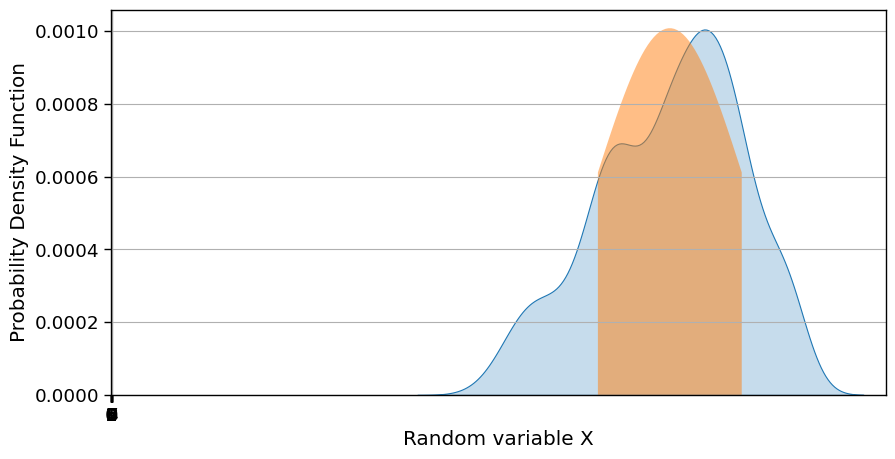

In [ ]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

# Line width: Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)
sns.set_context("paper", font_scale=1.5)

# Distribution
X=df["average_number_of_calories_available_per_person_per_day"]
mean = np.mean(X)
var = np.var(X)
std = np.std(X)

print("Mean:", mean)
print("Variance:", var)
print("Standard Deviation:", std)


plt.figure(figsize=(10, 5))

ax = sns.kdeplot(X, shade=True)

# Plot 1-std
x = np.linspace(mean - std, mean + std)
y = norm.pdf(x, mean, std)
ax.fill_between(x, y, alpha=0.5)

plt.xlabel("Random variable X")
plt.ylabel("Probability Density Function")
plt.xticks(ticks=range(0, 10))
plt.grid()

plt.show()